In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
import os
import json
import pylab as pl
import statsmodels.api as sm
import math
#s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns


Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [3]:
##remove

bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns


Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ddf2390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12e659f90>]], dtype=object)

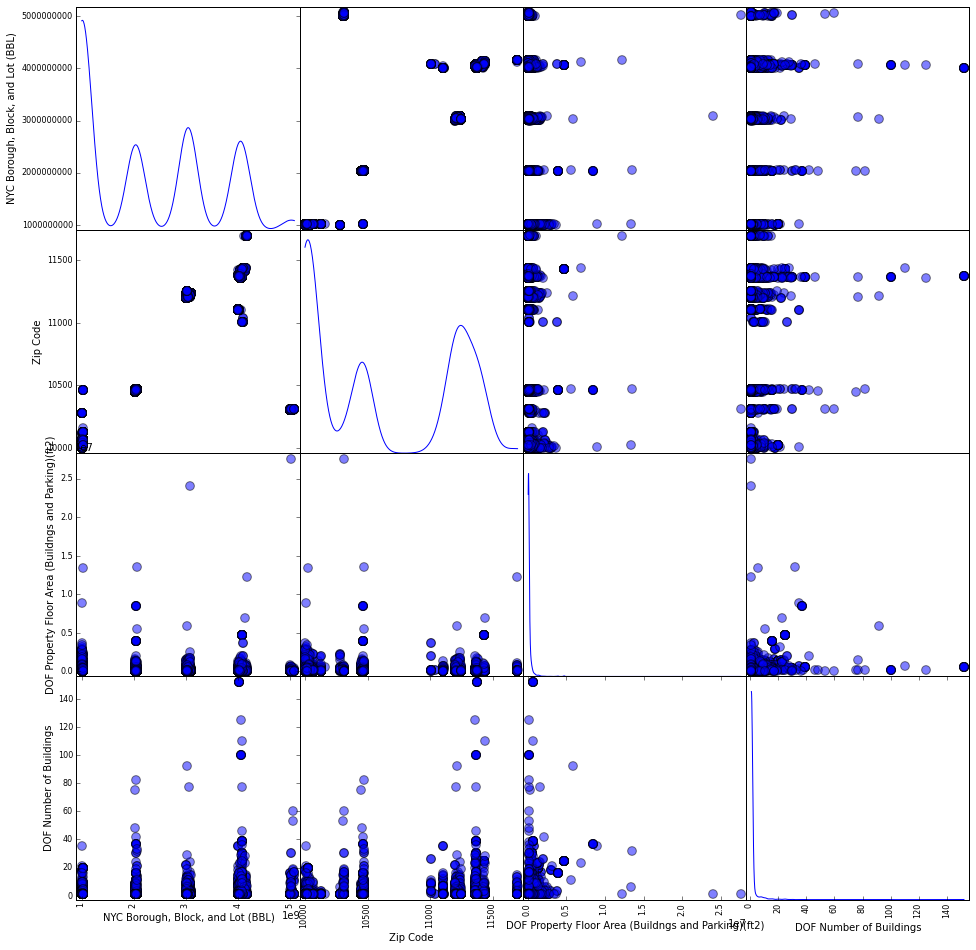

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')


it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [5]:
#convert ot float arrays
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [6]:
#create the indeces array here
indx = np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])

In [7]:
indx2 = (np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
indx3 = np.vectorize(canconvert)(bsize['BBL'])

In [8]:
nrg['Site EUI(kBtu/ft2)'][~indx]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx2]=float('NaN')
bsize['BBL'][~indx3]=float('NaN')

#etc etc... for all columns you care about

/Users/lucyy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lucyy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/lucyy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!
print bsize.BBL.astype(float)

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [10]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, on='BBL')
bblnrgdata[:10]

/Users/lucyy/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/lucyy/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough_x,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,1005050001,NaN,1005050001,1007817,150,VARICK STREET,Manhattan,10013,Filed,82.1,...,0,1926,None,10013,M1-6,None,None,None,12a,"POLYGON ((982849.6037999988 203886.2427999973,..."
1,1021420100,NaN,1021420100,1063495,4079,BROADWAY,Manhattan,10032,Filed,137.69999999999999,...,0,1924,None,10032,R8,None,None,None,3b,"POLYGON ((1001098.760600001 246912.0266000032,..."
2,1021750080,NaN,1021750080,1064235,60,SHERMAN AVENUE,Manhattan,10040,Filed,103.2,...,0,1920,None,10040,R7-2,None,None,None,3a,"POLYGON ((1004289.818000004 253753.9872000068,..."
3,1003360005,NaN,1003360005,1088884,16,BIALYSTOKER PLACE,Manhattan,10002,Filed,74,...,0,1982,Y,10002,R8,None,None,None,12c,"POLYGON ((988978.3273999989 200091.3113999963,..."
4,1008070028,NaN,1-00807-0028,1015181,119,WEST 31 STREET,Manhattan,10001,Filed,130,...,0,1912,None,10001,C6-4.5,None,None,None,8d,"POLYGON ((987142.3643999994 212082.1648000032,..."
5,1008580014,NaN,1-00858-0014,1016899,80,MADISON AVENUE,Manhattan,10016,Filed,138.30000000000001,...,0,1923,None,10016,C5-2,None,None,None,8d,"POLYGON ((988236.059799999 210446.8110000044, ..."
6,1009687501,NaN,1-00968-7501,1022060,630,1 AVENUE,Manhattan,10016,Filed,56909,...,0,1984,None,10016,C1-9,M1-5,None,None,8d,"POLYGON ((992204.4226000011 210789.5082000047,..."
7,1011390001,NaN,1-01139-0001,1028849,145,WEST 67 STREET,Manhattan,10023,Filed,88.2,...,0,1986,None,10023,C4-7,None,None,None,8c,"POLYGON ((988979.4684000015 221890.7784000039,..."
8,1012090148,NaN,1-01209-00148,1031751,NaN,NaN,Manhattan,NaN,Not on Covered Buildings List,15.7,...,0,1900,None,10025,R9,None,None,None,5d,"POLYGON ((993619.4018000066 227878.1987999976,..."
9,1005680024,NaN,1005680024,1032045,60,UNIVERSITY PLACE,Manhattan,10003,Filed,NaN,...,0,1926,None,10003,C1-7,R7-2,None,None,12c,"POLYGON ((985980.269600004 206319.3540000021, ..."


once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

In [11]:
#create eui = site area * buildings
bblnrgdata['EUITotal'] = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)*bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
print bblnrgdata['EUITotal']
print bblnrgdata['UnitsTotal'].astype(float)

0       1.932388e+07
1       8.923786e+06
2       6.484985e+06
3       7.252000e+06
4       2.657421e+07
5       8.313213e+06
6       2.606125e+10
7       4.507029e+07
8       8.861394e+05
9                NaN
10      6.721880e+06
11      1.571334e+07
12      8.304709e+06
13      7.611074e+07
14      8.857581e+07
15      7.286018e+06
16      5.401410e+06
17      6.619960e+06
18      1.715440e+06
19      4.870652e+06
20               NaN
21      3.643200e+06
22      4.235712e+07
23      8.150267e+06
24      4.539942e+06
25      4.937273e+06
26      4.323671e+07
27               NaN
28      1.368137e+07
29               NaN
            ...     
6515             NaN
6516             NaN
6517             NaN
6518             NaN
6519             NaN
6520             NaN
6521             NaN
6522             NaN
6523             NaN
6524             NaN
6525             NaN
6526             NaN
6527             NaN
6528             NaN
6529             NaN
6530             NaN
6531         

/Users/lucyy/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))


when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


In [12]:
#clean data
bblnrgdata_cut = bblnrgdata[(bblnrgdata['EUITotal']>1000) & (bblnrgdata['EUITotal']<1e10)]
bblnrgdata_cut = bblnrgdata[(bblnrgdata['UnitsTotal']<1000) & (bblnrgdata['UnitsTotal']>=1)]

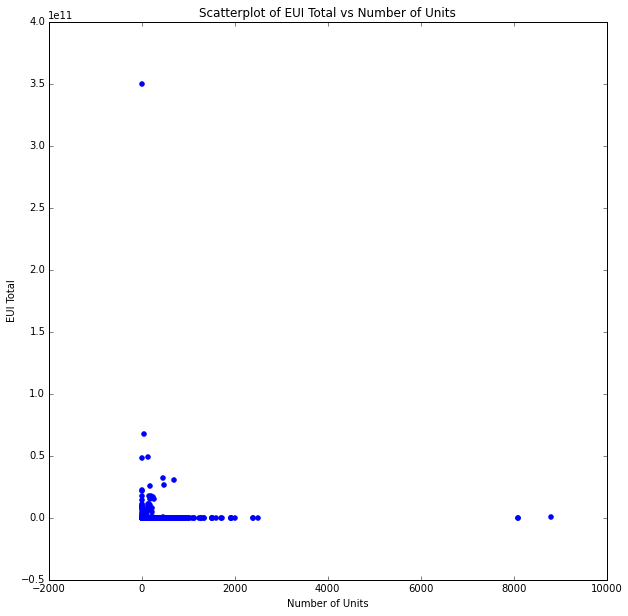

In [13]:
#plot energy vs number of units
pl.figure(figsize=(10,10))
pl.scatter(bblnrgdata['UnitsTotal'],bblnrgdata['EUITotal'], color='b')
pl.title('Scatterplot of EUI Total vs Number of Units')
pl.xlabel('Number of Units')
pl.ylabel('EUI Total')

Most of the buildings are below 3,000 units with total energy consumption below 1e10. 

(0, 10000000000.0)

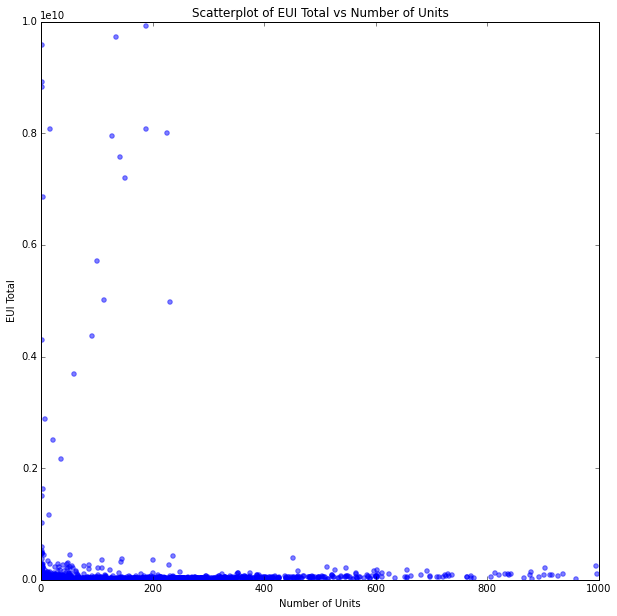

In [14]:
#plot clean data
pl.figure(figsize=(10,10))
pl.scatter(bblnrgdata_cut['UnitsTotal'],bblnrgdata_cut['EUITotal'], alpha=.5, s=20, color='b')
pl.title('Scatterplot of EUI Total vs Number of Units')
pl.xlabel('Number of Units')
pl.ylabel('EUI Total')
pl.xlim([0,1000])
pl.ylim([0,1e10])

After removing the "outliers", you can see how the plot is more condensed.

In [15]:
# Create log
UnitsLog = np.log10(bblnrgdata_cut['UnitsTotal'])
EUILog = np.log10(bblnrgdata_cut['EUITotal'])


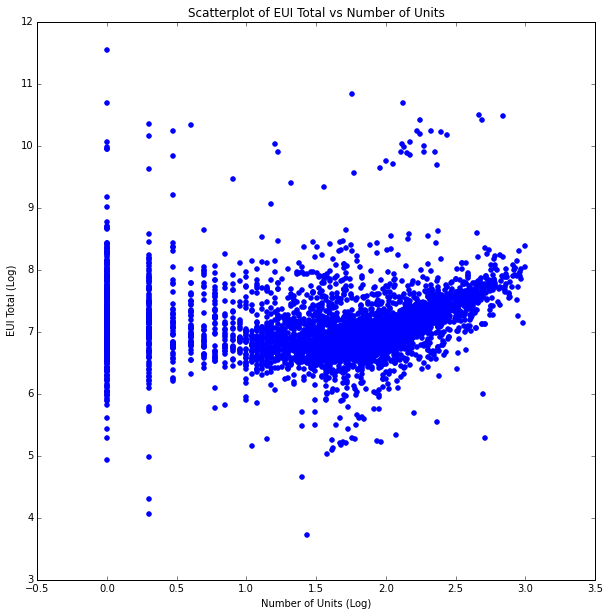

In [16]:
pl.figure(figsize=(10,10))
pl.scatter(UnitsLog, EUILog, color='b')
pl.title('Scatterplot of EUI Total vs Number of Units')
pl.xlabel('Number of Units (Log)')
pl.ylabel('EUI Total (Log)')


Above is the log for total energy and number of units, we can see it's scattered throughout graph showing that more buildings uses a slight more energy, not by too much though.

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [17]:
x = np.log10(bblnrgdata_cut.UnitsTotal)
y = np.log10(bblnrgdata_cut.EUITotal)
print x, y
X = sm.add_constant(x)
#print X
model = sm.OLS(y, X, missing='drop')#.fit() # ignores entires where x or y is NaN
fit = model.fit()
#fit.params[1], fit.params[0] # could also return stderr in each via fit.bse

0       1.380211
1       1.792392
2       1.929419
3       2.107210
4       1.000000
5       1.785330
6       2.686636
7       2.656098
8       1.000000
9       1.792392
10      1.832509
11      1.949390
12      0.954243
13      1.579784
14      0.698970
15      1.857332
16      1.748188
17      1.792392
18      1.977724
19      1.785330
20      1.755875
21      1.785330
22      2.720986
23      1.724276
24      1.633468
25      1.819544
26      2.290035
27      2.260071
28      1.623249
29      1.556303
          ...   
6514    1.748188
6515    1.892095
6517    0.301030
6518    2.502427
6519    1.732394
6520    1.799341
6521    1.380211
6522    1.832509
6523    1.079181
6524    1.531479
6525    2.056905
6526    1.230449
6527    1.954243
6528    0.000000
6529    2.296665
6530    1.778151
6531    2.469822
6532    2.584331
6533    0.000000
6534    0.000000
6535    1.880814
6536    1.748188
6537    0.000000
6538    1.176091
6539    1.397940
6540    1.230449
6541    0.000000
6542    0.7781

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


In [18]:
#fit and plots here
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EUITotal   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 18 Oct 2015   Prob (F-statistic):                nan
Time:                        14:03:00   Log-Likelihood:                    nan
No. Observations:                4982   AIC:                               nan
Df Residuals:                    4980   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const            -inf        nan        nan        nan           nan       nan
UnitsTotal        inf        nan        nan        nan           nan       nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         5.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [19]:
#answer the question here

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [20]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [21]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)

NameError: name 'bblnrgdatacut' is not defined